# Simulation 16: Mobility Cost Sweep

TJ Kim
4/27/20

Find performance based on batch size:
- 20 users, 10 servers, 12 ts
- Jobs last entire duration
- Resources, limited

Batch sizes to sweep:
- speeds to sweep: means <0.5,1,2> deviation = 0.3

In [1]:
from IPython.core.debugger import set_trace

# Import Generic Classes
import numpy as np
import copy
import pickle
import random

# Plot the plot
import matplotlib
import matplotlib.pyplot as plt

# Import All Custom Classes
import os, sys
sys.path.append(os.path.pardir+"/classes")
sys.path.append(os.path.pardir+"/solvers")
sys.path.append(os.path.pardir+"/one_mobility")
sys.path.append(os.path.curdir + "/sim_store/sim16")
sys.path.append(os.path.pardir+"/crawdad_mobility")


from Server import *
from User import *
from Link import *
from Job import *
from Migration_Plans import *
from Cost_Recordings import *

from load_crawdad_usr import *

from sim16_setting import *



# Import Solver Classes
from Optim_PlanGenerator import *
from SeqGreedy_PlanGenerator import *
from Myopic_PlanGenerator import *
from Naive_PlanGenerator import *
from Cloud_PlanGenerator import *

In [2]:
# Load Crawdad data
# Load All 12 users and trim their info
db_names = []
for i in range(1,13):
    db_names += ['LifeMap_GS'+str(i)+'.db']

db = []
for name in db_names:
    name = '/home/tkim/CMU/MEC_research/crawdad_mobility/' + name
    df,trace = load_usr(name)
    db += [trace]

In [3]:
def run_simul(speed,spd_var):

    num_trials = 2
    Batch_cost_stores = []
    SG_cost_stores = []
    Naive_cost_stores = []
    Myopic_cost_stores = []
    Cloud_cost_stores = []

    Batch_cost_stores_ample = []
    SG_cost_stores_ample = []
    Naive_cost_stores_ample = []
    Myopic_cost_stores_ample = []
    Cloud_cost_stores_ample = []

    for i in range(num_trials):

        print("Trial Number:",i)

        print("limited")

        while True:
            try:
                # Make Users
                users, servers, links, jobs, sim_param = simulation_setting(db, speed, spd_var)
                # Make Batch Prob 
                print("batch_prob...")
                Batch_prob = SeqGreedy_PlanGenerator(users, servers, links, jobs, sim_param)
                Batch_plan = Migration_Plans(users,jobs,sim_param)
                Batch_plan.from_seq_greedy(Batch_prob)
                Batch_cost_stores += [Cost_Recordings(Batch_plan)]
                print("done!")


                break
            except:
                print("batch_broken, repeating with new users")
                continue



        # users, servers, links, jobs, sim_param = simulation_setting(db)

        # Make SG Prob
        # Set Refresh to false for SG
        refresh_rate = [0,0]
        refresh = False

        jobs2 = copy.deepcopy(jobs)
        for j in range(len(jobs2)):
            jobs2[j].info_from_usr(users[j],refresh_rate,refresh)

        print("SG prob...")
        SG_prob = SeqGreedy_PlanGenerator(users, servers, links, jobs2, sim_param)
        SG_plan = Migration_Plans(users,jobs2,sim_param)
        SG_plan.from_seq_greedy(SG_prob)
        SG_cost_stores += [Cost_Recordings(SG_plan)]
        print("done!")

        # Make Cloud Prob
        print("Cloud prob...")
        Cloud_prob = Cloud_PlanGenerator(users, servers, links, jobs, sim_param)
        Cloud_plan = Migration_Plans(users,jobs,sim_param)
        Cloud_plan.from_seq_greedy(Cloud_prob)
        Cloud_cost_stores += [Cost_Recordings(Cloud_plan)]
        print("done!")

        # Make Naive Prob
        print("Naive prob...")
        Naive_prob = Naive_PlanGenerator(users, servers, links, jobs, sim_param)
        Naive_plan = Migration_Plans(users,jobs,sim_param)
        Naive_plan.from_seq_greedy(Naive_prob)
        Naive_cost_stores += [Cost_Recordings(Naive_plan)]
        print("done!")

        # Make Myopic Prob
        print("Myopic prob...")
        Myopic_prob = Myopic_PlanGenerator(users, servers, links, jobs, sim_param)
        Myopic_plan = Migration_Plans(users,jobs,sim_param)
        Myopic_plan.from_seq_greedy(Myopic_prob)
        Myopic_cost_stores += [Cost_Recordings(Myopic_plan)]
        print("done!")

        
        
        
    SG_total_sum = np.zeros(num_trials)
    SG_placement_sum = np.zeros(num_trials)
    SG_bw_sum = np.zeros(num_trials)
    SG_UE_sum = np.zeros(num_trials)

    Batch_total_sum = np.zeros(num_trials)
    Batch_placement_sum = np.zeros(num_trials)
    Batch_bw_sum = np.zeros(num_trials)
    Batch_UE_sum = np.zeros(num_trials)

    Myopic_total_sum = np.zeros(num_trials)
    Myopic_placement_sum = np.zeros(num_trials)
    Myopic_bw_sum = np.zeros(num_trials)
    Myopic_UE_sum = np.zeros(num_trials)

    Naive_total_sum = np.zeros(num_trials)
    Naive_placement_sum = np.zeros(num_trials)
    Naive_bw_sum = np.zeros(num_trials)
    Naive_UE_sum = np.zeros(num_trials)

    Cloud_total_sum = np.zeros(num_trials)
    Cloud_placement_sum = np.zeros(num_trials)
    Cloud_bw_sum = np.zeros(num_trials)
    Cloud_UE_sum = np.zeros(num_trials)

    for i in range(num_trials):

        SG_total_sum[i] += SG_cost_stores[i].all_cost_cumulative["total_cost"][-1]
        SG_placement_sum[i] += SG_cost_stores[i].all_cost_cumulative["placement_cost"][-1]
        SG_bw_sum[i] += SG_cost_stores[i].all_cost_cumulative["srv_bw_cost"][-1]
        SG_bw_sum[i] += SG_cost_stores[i].all_cost_cumulative["mig_bw_cost"][-1]
        SG_UE_sum[i] += SG_cost_stores[i].all_cost_cumulative["thruput_cost"][-1]
        SG_UE_sum[i] += SG_cost_stores[i].all_cost_cumulative["latency_cost"][-1]

        Batch_total_sum[i] += Batch_cost_stores[i].all_cost_cumulative["total_cost"][-1]
        Batch_placement_sum[i] += Batch_cost_stores[i].all_cost_cumulative["placement_cost"][-1]
        Batch_bw_sum[i] += Batch_cost_stores[i].all_cost_cumulative["srv_bw_cost"][-1]
        Batch_bw_sum[i] += Batch_cost_stores[i].all_cost_cumulative["mig_bw_cost"][-1]
        Batch_UE_sum[i] += Batch_cost_stores[i].all_cost_cumulative["thruput_cost"][-1]
        Batch_UE_sum[i] += Batch_cost_stores[i].all_cost_cumulative["latency_cost"][-1]

        Myopic_total_sum[i] += Myopic_cost_stores[i].all_cost_cumulative["total_cost"][-1]
        Myopic_placement_sum[i] += Myopic_cost_stores[i].all_cost_cumulative["placement_cost"][-1]
        Myopic_bw_sum[i] += Myopic_cost_stores[i].all_cost_cumulative["srv_bw_cost"][-1]
        Myopic_bw_sum[i] += Myopic_cost_stores[i].all_cost_cumulative["mig_bw_cost"][-1]
        Myopic_UE_sum[i] += Myopic_cost_stores[i].all_cost_cumulative["thruput_cost"][-1]
        Myopic_UE_sum[i] += Myopic_cost_stores[i].all_cost_cumulative["latency_cost"][-1]

        Naive_total_sum[i] += Naive_cost_stores[i].all_cost_cumulative["total_cost"][-1]
        Naive_placement_sum[i] += Naive_cost_stores[i].all_cost_cumulative["placement_cost"][-1]
        Naive_bw_sum[i] += Naive_cost_stores[i].all_cost_cumulative["srv_bw_cost"][-1]
        Naive_bw_sum[i] += Naive_cost_stores[i].all_cost_cumulative["mig_bw_cost"][-1]
        Naive_UE_sum[i] += Naive_cost_stores[i].all_cost_cumulative["thruput_cost"][-1]
        Naive_UE_sum[i] += Naive_cost_stores[i].all_cost_cumulative["latency_cost"][-1]

        Cloud_total_sum[i] += Cloud_cost_stores[i].all_cost_cumulative["total_cost"][-1]
        Cloud_placement_sum[i] += Cloud_cost_stores[i].all_cost_cumulative["placement_cost"][-1]
        Cloud_bw_sum[i] += Cloud_cost_stores[i].all_cost_cumulative["srv_bw_cost"][-1]
        Cloud_bw_sum[i] += Cloud_cost_stores[i].all_cost_cumulative["mig_bw_cost"][-1]
        Cloud_UE_sum[i] += Cloud_cost_stores[i].all_cost_cumulative["thruput_cost"][-1]
        Cloud_UE_sum[i] += Cloud_cost_stores[i].all_cost_cumulative["latency_cost"][-1]
        


    # Set Font Size Limitations
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 17}

    matplotlib.rc('font', **font)

    # Set Labels
    labels = ['Total', 'Placement', 'BW', 'UE']

    # Obtain Values to Plot
    SG_means = [np.mean(SG_total_sum), np.mean(SG_placement_sum), np.mean(SG_bw_sum), np.mean(SG_UE_sum)]
    Batch_means = [np.mean(Batch_total_sum), np.mean(Batch_placement_sum), np.mean(Batch_bw_sum), np.mean(Batch_UE_sum)]
    Myopic_means = [np.mean(Myopic_total_sum), np.mean(Myopic_placement_sum), np.mean(Myopic_bw_sum), np.mean(Myopic_UE_sum)]
    Naive_means = [np.mean(Naive_total_sum), np.mean(Naive_placement_sum), np.mean(Naive_bw_sum), np.mean(Naive_UE_sum)]
    Cloud_means = [np.mean(Cloud_total_sum), np.mean(Cloud_placement_sum), np.mean(Cloud_bw_sum), np.mean(Cloud_UE_sum)]


    SG_var = [np.std(SG_total_sum), np.std(SG_placement_sum), np.std(SG_bw_sum), np.std(SG_UE_sum)]
    Batch_var = [np.std(Batch_total_sum), np.std(Batch_placement_sum), np.std(Batch_bw_sum), np.std(Batch_UE_sum)]
    Myopic_var = [np.std(Myopic_total_sum), np.std(Myopic_placement_sum), np.std(Myopic_bw_sum), np.std(Myopic_UE_sum)]
    Naive_var = [np.std(Naive_total_sum), np.std(Naive_placement_sum), np.std(Naive_bw_sum), np.std(Naive_UE_sum)]
    Cloud_var = [np.std(Cloud_total_sum), np.std(Cloud_placement_sum), np.std(Cloud_bw_sum), np.std(Cloud_UE_sum)]


    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x = x - width/2, height =  Batch_means, yerr = Batch_var,
                    capsize = 3, width = width/4, label='Batch', color='orange')
    rects2 = ax.bar(x = x - width/4, height = SG_means, yerr = SG_var, 
                    capsize = 3, width = width/4, label='Seq-Greedy', color = 'green')
    rects5 = ax.bar(x = x, height = Cloud_means, yerr = Cloud_var, 
                    capsize = 3, width = width/4, label='Cloud', color = 'blue')
    rects3 = ax.bar(x = x + width/4, height =  Myopic_means, yerr = Myopic_var,
                    capsize = 3, width = width/4, label='Myopic', color='orange',hatch='//')
    rects4 = ax.bar(x = x + width/2, height = Naive_means, yerr = Naive_var, 
                    capsize = 3, width = width/4, label='Naive', color = 'green',hatch='//')


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Monetary Cost (Dollars)')
    ax.set_title('Heuristic and Baseline Sub-Cost spd-'+str(speed))
    ax.set_xticks(x)
    # ax.set_xlabel('Cost Type')
    ax.set_xticklabels(labels)
    ax.legend()

    # Set Y axis to zero
    plt.ylim(0,)

    fig.tight_layout()

    plt.show()

Trial Number: 0
limited
batch_prob...
Struck Placement Resource (j,s,t): 10 0 0
Struck Placement Resource (j,s,t): 10 0 1
Struck Placement Resource (j,s,t): 11 4 1
Struck Placement Resource (j,s,t): 11 4 2
Struck Placement Resource (j,s,t): 11 4 0
Struck Placement Resource (j,s,t): 12 2 0
Struck Placement Resource (j,s,t): 12 2 1
Struck Placement Resource (j,s,t): 12 2 2
Struck Placement Resource (j,s,t): 13 0 0
Struck Placement Resource (j,s,t): 13 0 1
Struck Placement Resource (j,s,t): 13 0 2
Struck Placement Resource (j,s,t): 14 3 0
Struck Placement Resource (j,s,t): 14 3 1
Struck Placement Resource (j,s,t): 15 0 0
Struck Placement Resource (j,s,t): 15 0 1
Struck Placement Resource (j,s,t): 15 0 2
Struck Placement Resource (j,s,t): 17 4 0
Struck Placement Resource (j,s,t): 17 4 1
Struck Placement Resource (j,s,t): 17 4 2
Struck Placement Resource (j,s,t): 11 4 3
Struck Placement Resource (j,s,t): 11 4 4
Struck Placement Resource (j,s,t): 12 2 3
Struck Placement Resource (j,s,t): 12 

Struck Placement Resource (j,s,t): 10 0 2
Struck Placement Resource (j,s,t): 12 2 2
Struck Placement Resource (j,s,t): 13 0 2
Struck Placement Resource (j,s,t): 14 3 2
Struck Placement Resource (j,s,t): 15 0 2
Struck Placement Resource (j,s,t): 4 4 3
Struck Placement Resource (j,s,t): 7 4 3
Struck Placement Resource (j,s,t): 12 2 3
Struck Placement Resource (j,s,t): 13 0 3
Struck Placement Resource (j,s,t): 4 4 4
Struck Placement Resource (j,s,t): 7 4 4
Struck Placement Resource (j,s,t): 12 2 4
Struck Placement Resource (j,s,t): 4 4 5
Struck Placement Resource (j,s,t): 7 4 5
Struck Placement Resource (j,s,t): 12 2 5
Struck Placement Resource (j,s,t): 17 5 5
Struck Placement Resource (j,s,t): 7 4 6
Struck Placement Resource (j,s,t): 17 5 6
Struck Placement Resource (j,s,t): 7 4 7
Struck Placement Resource (j,s,t): 12 3 7
Struck Placement Resource (j,s,t): 17 5 7
Struck Placement Resource (j,s,t): 7 4 8
Struck Placement Resource (j,s,t): 12 3 8
Struck Placement Resource (j,s,t): 17 5 8
S

Struck Placement Resource (j,s,t): 3 1 6
Struck Placement Resource (j,s,t): 18 4 6
Struck Placement Resource (j,s,t): 18 4 7
Struck Placement Resource (j,s,t): 13 3 8
Struck Placement Resource (j,s,t): 15 4 8
Struck Placement Resource (j,s,t): 18 4 8
Struck Placement Resource (j,s,t): 13 3 9
Struck Placement Resource (j,s,t): 15 4 9
Struck Placement Resource (j,s,t): 16 2 9


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


done!


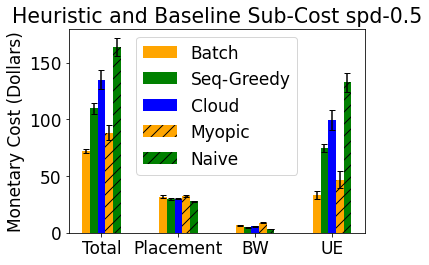

Trial Number: 0
limited
batch_prob...
Struck Placement Resource (j,s,t): 6 0 0
Struck Placement Resource (j,s,t): 6 0 1
Struck Placement Resource (j,s,t): 6 0 2
Struck Placement Resource (j,s,t): 14 3 0
Struck Placement Resource (j,s,t): 14 3 1
Struck Placement Resource (j,s,t): 17 0 0
Struck Placement Resource (j,s,t): 17 0 1
Struck Placement Resource (j,s,t): 19 0 0
Struck Placement Resource (j,s,t): 19 0 1
Struck Placement Resource (j,s,t): 19 0 2
Struck Placement Resource (j,s,t): 19 6 0
Struck Placement Resource (j,s,t): 19 6 1
Struck Placement Resource (j,s,t): 0 5 3
Struck Placement Resource (j,s,t): 5 5 3
Struck Placement Resource (j,s,t): 5 5 4
Struck Placement Resource (j,s,t): 9 5 4
Struck Placement Resource (j,s,t): 16 7 4
Struck Placement Resource (j,s,t): 17 7 3
Struck Placement Resource (j,s,t): 17 7 4
Struck Placement Resource (j,s,t): 18 8 3
Struck Placement Resource (j,s,t): 5 5 5
Struck Placement Resource (j,s,t): 6 7 5
Struck Placement Resource (j,s,t): 7 7 5
Struck

Struck Placement Resource (j,s,t): 13 8 4
Struck Placement Resource (j,s,t): 13 8 5
Struck Placement Resource (j,s,t): 13 8 6
ban_node: 46
ban_node: 57
ban_node: 68
ban_node: 47
ban_node: 58
ban_node: 69
ban_node: 48
ban_node: 59
ban_node: 70
ban_node: 49
ban_node: 60
ban_node: 71
ban_node: 50
ban_node: 61
ban_node: 72
ban_node: 51
ban_node: 62
ban_node: 73
ban_node: 52
ban_node: 63
ban_node: 74
ban_node: 53
ban_node: 64
ban_node: 75
ban_node: 54
ban_node: 65
ban_node: 76
Struck Placement Resource (j,s,t): 13 8 7
ban_node: 79
ban_node: 80
ban_node: 81
ban_node: 82
ban_node: 83
ban_node: 84
ban_node: 85
ban_node: 86
ban_node: 87
Struck Placement Resource (j,s,t): 15 8 3
Struck Placement Resource (j,s,t): 15 8 6
ban_node: 35
ban_node: 68
ban_node: 36
ban_node: 69
ban_node: 37
ban_node: 70
ban_node: 38
ban_node: 71
ban_node: 39
ban_node: 72
ban_node: 40
ban_node: 73
ban_node: 41
ban_node: 74
ban_node: 42
ban_node: 75
ban_node: 43
ban_node: 76
Struck Placement Resource (j,s,t): 15 8 4
Stru

Struck Placement Resource (j,s,t): 6 3 2
Struck Placement Resource (j,s,t): 15 0 0
Struck Placement Resource (j,s,t): 15 0 1
Struck Placement Resource (j,s,t): 15 0 2
Struck Placement Resource (j,s,t): 16 4 0
Struck Placement Resource (j,s,t): 16 4 1
Struck Placement Resource (j,s,t): 2 8 3
Struck Placement Resource (j,s,t): 18 1 3
Struck Placement Resource (j,s,t): 18 0 4
Struck Placement Resource (j,s,t): 5 1 5
Struck Placement Resource (j,s,t): 11 6 5
Struck Placement Resource (j,s,t): 15 8 5
Struck Placement Resource (j,s,t): 15 4 5
Struck Placement Resource (j,s,t): 17 8 6
Struck Placement Resource (j,s,t): 18 0 5
Struck Placement Resource (j,s,t): 18 8 6
Struck Placement Resource (j,s,t): 4 4 7
Struck Placement Resource (j,s,t): 10 4 7
Struck Placement Resource (j,s,t): 11 4 7
Struck Placement Resource (j,s,t): 12 2 8
Struck Placement Resource (j,s,t): 14 4 7
Struck Placement Resource (j,s,t): 15 2 8
Struck Placement Resource (j,s,t): 16 0 7
Struck Placement Resource (j,s,t): 16 

Struck Placement Resource (j,s,t): 18 8 6
Struck Placement Resource (j,s,t): 18 8 7
Struck Placement Resource (j,s,t): 18 8 8
Struck Placement Resource (j,s,t): 18 8 9
ban_node: 68
ban_node: 79
ban_node: 90
ban_node: 101
ban_node: 69
ban_node: 80
ban_node: 91
ban_node: 102
ban_node: 70
ban_node: 81
ban_node: 92
ban_node: 103
ban_node: 71
ban_node: 82
ban_node: 93
ban_node: 104
ban_node: 72
ban_node: 83
ban_node: 94
ban_node: 105
ban_node: 73
ban_node: 84
ban_node: 95
ban_node: 106
ban_node: 74
ban_node: 85
ban_node: 96
ban_node: 107
ban_node: 75
ban_node: 86
ban_node: 97
ban_node: 108
ban_node: 76
ban_node: 87
ban_node: 98
ban_node: 109
Struck Placement Resource (j,s,t): 19 7 6
Struck Placement Resource (j,s,t): 19 8 7
Struck Placement Resource (j,s,t): 19 8 8
Struck Placement Resource (j,s,t): 19 8 9
ban_node: 68
ban_node: 79
ban_node: 90
ban_node: 101
ban_node: 69
ban_node: 80
ban_node: 91
ban_node: 102
ban_node: 70
ban_node: 81
ban_node: 92
ban_node: 103
ban_node: 71
ban_node: 82
ba

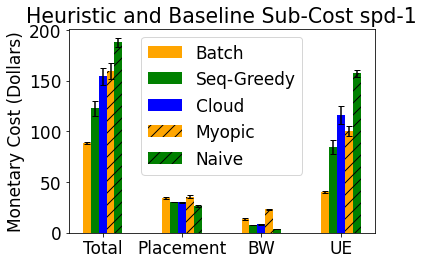

Trial Number: 0
limited
batch_prob...
Struck Placement Resource (j,s,t): 2 0 0
Struck Placement Resource (j,s,t): 2 0 1
Struck Placement Resource (j,s,t): 2 0 2
Struck Placement Resource (j,s,t): 5 0 0
Struck Placement Resource (j,s,t): 5 0 1
Struck Placement Resource (j,s,t): 5 0 2
Struck Placement Resource (j,s,t): 8 0 0
Struck Placement Resource (j,s,t): 8 0 1
Struck Placement Resource (j,s,t): 9 0 0
Struck Placement Resource (j,s,t): 9 0 1
Struck Placement Resource (j,s,t): 9 0 2
Struck Placement Resource (j,s,t): 9 6 0
Struck Placement Resource (j,s,t): 9 6 1
Struck Placement Resource (j,s,t): 9 6 2
Struck Placement Resource (j,s,t): 10 0 0
Struck Placement Resource (j,s,t): 10 6 1
Struck Placement Resource (j,s,t): 10 6 2
Struck Placement Resource (j,s,t): 10 6 0
Struck Placement Resource (j,s,t): 13 1 0
Struck Placement Resource (j,s,t): 16 5 0
Struck Placement Resource (j,s,t): 17 6 1
Struck Placement Resource (j,s,t): 17 6 2
Struck Placement Resource (j,s,t): 18 0 1
Struck Pla

Struck Placement Resource (j,s,t): 15 0 0
Struck Placement Resource (j,s,t): 15 6 2
Struck Placement Resource (j,s,t): 15 0 1
Struck Placement Resource (j,s,t): 15 6 1
Struck Placement Resource (j,s,t): 15 6 0
Struck Placement Resource (j,s,t): 16 5 0
Struck Placement Resource (j,s,t): 17 8 1
Struck Placement Resource (j,s,t): 17 6 2
Struck Placement Resource (j,s,t): 17 8 0
Struck Placement Resource (j,s,t): 17 0 2
Struck Placement Resource (j,s,t): 17 6 1
Struck Placement Resource (j,s,t): 17 8 2
Struck Placement Resource (j,s,t): 19 0 0
Struck Placement Resource (j,s,t): 19 6 1
Struck Placement Resource (j,s,t): 19 6 2
Struck Placement Resource (j,s,t): 19 8 2
Struck Placement Resource (j,s,t): 19 6 0
Struck Placement Resource (j,s,t): 1 6 3
Struck Placement Resource (j,s,t): 4 6 3
Struck Placement Resource (j,s,t): 5 0 3
Struck Placement Resource (j,s,t): 5 6 3
Struck Placement Resource (j,s,t): 8 0 3
Struck Placement Resource (j,s,t): 11 6 3
Struck Placement Resource (j,s,t): 11 0

Struck Placement Resource (j,s,t): 3 0 0
ban_node: 2
ban_node: 3
ban_node: 4
ban_node: 5
ban_node: 6
ban_node: 7
ban_node: 8
ban_node: 9
ban_node: 10
Struck Placement Resource (j,s,t): 9 0 0
ban_node: 2
ban_node: 3
ban_node: 4
ban_node: 5
ban_node: 6
ban_node: 7
ban_node: 8
ban_node: 9
ban_node: 10
Struck Placement Resource (j,s,t): 9 0 1
ban_node: 13
ban_node: 14
ban_node: 15
ban_node: 16
ban_node: 17
ban_node: 18
ban_node: 19
ban_node: 20
ban_node: 21
Struck Placement Resource (j,s,t): 10 7 6
Struck Placement Resource (j,s,t): 10 7 7
ban_node: 68
ban_node: 79
ban_node: 69
ban_node: 80
ban_node: 70
ban_node: 81
ban_node: 71
ban_node: 82
ban_node: 72
ban_node: 83
ban_node: 73
ban_node: 84
ban_node: 74
ban_node: 85
ban_node: 75
ban_node: 86
ban_node: 76
ban_node: 87
Struck Placement Resource (j,s,t): 10 7 8
ban_node: 90
ban_node: 91
ban_node: 92
ban_node: 93
ban_node: 94
ban_node: 95
ban_node: 96
ban_node: 97
ban_node: 98
Struck Placement Resource (j,s,t): 11 7 6
Struck Placement Resour

Struck Placement Resource (j,s,t): 3 0 0
Struck Placement Resource (j,s,t): 3 0 1
Struck Placement Resource (j,s,t): 3 0 2
Struck Placement Resource (j,s,t): 3 0 3
Struck Placement Resource (j,s,t): 3 0 4
Struck Placement Resource (j,s,t): 3 0 5
Struck Placement Resource (j,s,t): 3 0 6
Struck Placement Resource (j,s,t): 3 0 7
Struck Placement Resource (j,s,t): 3 0 8
Struck Placement Resource (j,s,t): 3 0 9
Struck Placement Resource (j,s,t): 9 0 0
Struck Placement Resource (j,s,t): 9 0 1
Struck Placement Resource (j,s,t): 9 0 2
Struck Placement Resource (j,s,t): 9 0 3
Struck Placement Resource (j,s,t): 9 0 4
Struck Placement Resource (j,s,t): 9 0 5
Struck Placement Resource (j,s,t): 9 0 6
Struck Placement Resource (j,s,t): 9 0 7
Struck Placement Resource (j,s,t): 9 0 8
Struck Placement Resource (j,s,t): 9 0 9
Struck Placement Resource (j,s,t): 13 0 0
Struck Placement Resource (j,s,t): 13 0 1
Struck Placement Resource (j,s,t): 13 0 2
Struck Placement Resource (j,s,t): 13 0 3
Struck Place

Struck Placement Resource (j,s,t): 16 0 8
Struck Placement Resource (j,s,t): 16 6 8
Struck Placement Resource (j,s,t): 18 2 8
Struck Placement Resource (j,s,t): 18 7 8
Struck Placement Resource (j,s,t): 18 5 8
Struck Placement Resource (j,s,t): 19 4 8
Struck Placement Resource (j,s,t): 4 3 9
Struck Placement Resource (j,s,t): 5 3 9
Struck Placement Resource (j,s,t): 11 3 9
Struck Placement Resource (j,s,t): 13 2 9
Struck Placement Resource (j,s,t): 15 2 9
Struck Placement Resource (j,s,t): 16 2 9
Struck Placement Resource (j,s,t): 16 7 9
Struck Placement Resource (j,s,t): 16 5 9
done!
Trial Number: 1
limited
batch_prob...
Struck Placement Resource (j,s,t): 5 5 0
Struck Placement Resource (j,s,t): 5 5 1
Struck Placement Resource (j,s,t): 6 0 0
Struck Placement Resource (j,s,t): 6 0 1
Struck Placement Resource (j,s,t): 8 0 0
Struck Placement Resource (j,s,t): 9 5 0
Struck Placement Resource (j,s,t): 10 0 0
Struck Placement Resource (j,s,t): 12 6 0
Struck Placement Resource (j,s,t): 15 5 

Struck Placement Resource (j,s,t): 9 0 1
Struck Placement Resource (j,s,t): 9 6 1
Struck Placement Resource (j,s,t): 9 6 2
Struck Placement Resource (j,s,t): 11 6 1
Struck Placement Resource (j,s,t): 11 6 2
Struck Placement Resource (j,s,t): 11 6 0
Struck Placement Resource (j,s,t): 13 0 0
Struck Placement Resource (j,s,t): 14 6 1
Struck Placement Resource (j,s,t): 14 6 2
Struck Placement Resource (j,s,t): 14 6 0
Struck Placement Resource (j,s,t): 14 0 0
Struck Placement Resource (j,s,t): 15 0 0
Struck Placement Resource (j,s,t): 17 8 2
Struck Placement Resource (j,s,t): 18 8 1
Struck Placement Resource (j,s,t): 18 8 2
Struck Placement Resource (j,s,t): 18 6 1
Struck Placement Resource (j,s,t): 18 6 2
Struck Placement Resource (j,s,t): 19 6 1
Struck Placement Resource (j,s,t): 19 6 2
Struck Placement Resource (j,s,t): 6 6 3
Struck Placement Resource (j,s,t): 7 6 3
Struck Placement Resource (j,s,t): 10 0 3
Struck Placement Resource (j,s,t): 10 0 4
Struck Placement Resource (j,s,t): 10 6

Struck Placement Resource (j,s,t): 6 5 7
Struck Placement Resource (j,s,t): 11 5 7
Struck Placement Resource (j,s,t): 11 7 7
Struck Placement Resource (j,s,t): 12 2 7
Struck Placement Resource (j,s,t): 12 2 8
Struck Placement Resource (j,s,t): 12 7 7
Struck Placement Resource (j,s,t): 12 7 8
Struck Placement Resource (j,s,t): 12 2 6
not enough resources, simulation broken
batch_broken, repeating with new users
batch_prob...
Struck Placement Resource (j,s,t): 12 2 0
Struck Placement Resource (j,s,t): 16 0 0
Struck Placement Resource (j,s,t): 16 6 0
Struck Placement Resource (j,s,t): 16 6 1
Struck Placement Resource (j,s,t): 17 0 0
Struck Placement Resource (j,s,t): 17 0 1
Struck Placement Resource (j,s,t): 17 6 0
Struck Placement Resource (j,s,t): 17 6 1
Struck Placement Resource (j,s,t): 17 6 2
Struck Placement Resource (j,s,t): 18 6 0
Struck Placement Resource (j,s,t): 18 6 1
Struck Placement Resource (j,s,t): 18 6 2
Struck Placement Resource (j,s,t): 0 6 3
Struck Placement Resource (

Struck Placement Resource (j,s,t): 17 8 1
Struck Placement Resource (j,s,t): 17 8 2
Struck Placement Resource (j,s,t): 17 1 0
Struck Placement Resource (j,s,t): 17 7 3
Struck Placement Resource (j,s,t): 17 6 1
Struck Placement Resource (j,s,t): 17 6 2
Struck Placement Resource (j,s,t): 17 6 4
Struck Placement Resource (j,s,t): 17 6 5
Struck Placement Resource (j,s,t): 17 6 6
Struck Placement Resource (j,s,t): 17 6 7
Struck Placement Resource (j,s,t): 17 8 3
Struck Placement Resource (j,s,t): 17 6 3
Struck Placement Resource (j,s,t): 17 7 4
Struck Placement Resource (j,s,t): 17 8 4
Struck Placement Resource (j,s,t): 17 7 2
Struck Placement Resource (j,s,t): 18 8 0
Struck Placement Resource (j,s,t): 18 8 2
Struck Placement Resource (j,s,t): 18 7 6
Struck Placement Resource (j,s,t): 18 7 4
Struck Placement Resource (j,s,t): 18 7 5
Struck Placement Resource (j,s,t): 18 6 7
Struck Placement Resource (j,s,t): 18 8 3
Struck Placement Resource (j,s,t): 18 6 6
Struck Placement Resource (j,s,t):

Struck Placement Resource (j,s,t): 16 1 0
Struck Placement Resource (j,s,t): 16 1 1
Struck Placement Resource (j,s,t): 17 1 0
Struck Placement Resource (j,s,t): 17 1 1
Struck Placement Resource (j,s,t): 19 1 0
Struck Placement Resource (j,s,t): 19 1 1
Struck Placement Resource (j,s,t): 2 2 2
Struck Placement Resource (j,s,t): 3 0 2
Struck Placement Resource (j,s,t): 6 8 2
Struck Placement Resource (j,s,t): 8 2 2
Struck Placement Resource (j,s,t): 10 0 2
Struck Placement Resource (j,s,t): 11 2 2
Struck Placement Resource (j,s,t): 14 8 2
Struck Placement Resource (j,s,t): 16 1 2
Struck Placement Resource (j,s,t): 18 1 2
Struck Placement Resource (j,s,t): 2 3 3
Struck Placement Resource (j,s,t): 8 3 3
Struck Placement Resource (j,s,t): 11 3 3
Struck Placement Resource (j,s,t): 16 1 3
Struck Placement Resource (j,s,t): 17 1 3
Struck Placement Resource (j,s,t): 19 1 3
Struck Placement Resource (j,s,t): 2 4 4
Struck Placement Resource (j,s,t): 8 4 4
Struck Placement Resource (j,s,t): 9 1 4
S

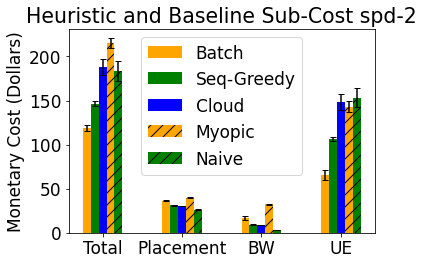

In [4]:
speeds = [0.5,1,2]
var = 0.3

for speed in speeds:
    run_simul(speed,var)